In [1]:
import sklearn
from config import PASSWORD, HOST, USER
import psycopg2
from psycopg2 import Error
import pandas.io.sql as psql
import matplotlib

## Import data from database

In [2]:
# output records from a query as a dataframe 
def get_dataframe(query):
    try:
        # Connect to an existing database
        connection = psycopg2.connect(user=USER,
                                      password=PASSWORD,
                                      host=HOST,
                                      port="15432",
                                      database="group_12")

        df = psql.read_sql(query, connection)


    except (Exception, Error) as error:
        print("Error while connecting to PostgreSQL", error)
    finally:
        if (connection):
            connection.close()
            
    return df


In [3]:
fact_df = get_dataframe("SELECT * FROM fact")
print(fact_df.shape)
fact_df.head(2)

(47905, 14)


,test_date_id,reported_date_id,specimen_date_id,onset_date_id,holiday_id,loc_id,weather_id,restriction_group_id,person_id,test_facility_id,resolved,unresolved,fatal,outbreak
0,128,290,128,124,0,77,77,14,1,3,1,0,0,0
1,211,302,209,300,0,577,211,14,18,4,1,0,0,0


In [4]:
phu_df = get_dataframe("SELECT * FROM phu")
print(phu_df.shape)
phu_df.head(1)

(6, 10)


,phu_key,postal_code,phu_name,address,city,province,url,latitude,longitude,municipality
0,0,Ontario,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893,Peel


In [5]:
weather_df = get_dataframe("SELECT * FROM weather")
print(weather_df.shape)
weather_df.head(2)

(244, 8)


,weather_key,longitude,latitude,station_name,mean_tempreture,total_precipitation_mm,snow,rain
0,0,-75.72,45.38,OTTAWA CDA,22.8,0.0,False,False
1,1,-75.72,45.38,OTTAWA CDA,21.5,36.0,False,True


In [6]:
mob_df= get_dataframe("SELECT * FROM mobility_trends")
print(mob_df.shape)
mob_df.head()

(732, 10)


,mobility_key,country,province,municipality,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,0,Canada,Ontario,Ottawa,-26.0,-9.0,181.0,-32.0,-2.0,0.0
1,1,Canada,Ontario,Ottawa,-25.0,-11.0,2.0,-46.0,-7.0,3.0
2,2,Canada,Ontario,Ottawa,-35.0,-24.0,137.0,-67.0,-77.0,17.0
3,3,Canada,Ontario,Ottawa,-27.0,-8.0,-21.0,-62.0,-61.0,19.0
4,4,Canada,Ontario,Ottawa,-20.0,1.0,59.0,-60.0,-58.0,17.0


In [7]:
holiday_df = get_dataframe("SELECT * FROM holiday")
print(holiday_df.shape)

(17, 4)


In [8]:
person_df = get_dataframe("SELECT * FROM person")
print(person_df.shape)
person_df.head(1)

(178, 4)


,person_id,age_group,gender,case_acquisition
0,0,20s,MALE,CC


In [49]:
date_df = get_dataframe("SELECT * FROM date")
print(date_df.shape)
date_df.head(1)

(397, 9)


,date_id,month_name,month_num,day_name,day_num,date,year,week_of_year,week_of_month
0,0,January,1,Wednesday,4,2020-01-01,2020,1,1


## Create graphs

In [ ]:
# some joins to create new tables
fact_phu_df = fact_df[["test_facility_id","resolved","fatal","unresolved"]].merge(phu_df, left_on = "test_facility_id", right_on = "phu_key", how='left').groupby("phu_name").sum()
print(fact_phu_df.head())

fact_df_person = fact_df[["resolved","fatal","unresolved","person_id"]].merge(person_df,left_on = "person_id", right_on = "person_id", how='left' ).groupby(["age_group","gender"]).sum()
print(fact_df_person.head(10))

In [110]:
reported_date_fact_df = fact_df[["resolved","fatal","reported_date_id","loc_id","weather_id","person_id","outbreak"]].merge(date_df, left_on = "reported_date_id", right_on = "date_id", how='left')
reported_date_fact_df = reported_date_fact_df.merge(weather_df, left_on = "weather_id", right_on = "weather_key", how='left')
reported_date_fact_df = reported_date_fact_df[["outbreak","person_id","loc_id","resolved","fatal","day_name","date_id","week_of_year","month_name","mean_tempreture","total_precipitation_mm"]]
reported_date_fact_df = reported_date_fact_df.merge(mob_df, left_on = "loc_id", right_on = "mobility_key", how='left')
reported_date_fact_df = reported_date_fact_df.merge(person_df, left_on = "person_id", right_on = "person_id", how='left')

reported_date_fact_df.head(2)


,outbreak,person_id,loc_id,resolved,fatal,day_name,date_id,week_of_year,month_name,mean_tempreture,...,municipality,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,age_group,gender,case_acquisition
0,0,1,77,1,0,Saturday,290,42,October,6.8,...,Ottawa,-25.0,-2.0,107.0,-46.0,-7.0,6.0,50s,MALE,CC
1,0,18,577,1,0,Thursday,302,44,October,6.5,...,York,-25.0,4.0,34.0,-58.0,-43.0,19.0,80s,MALE,CC


### Boxplots

Percent changes for types of locations


<AxesSubplot:>

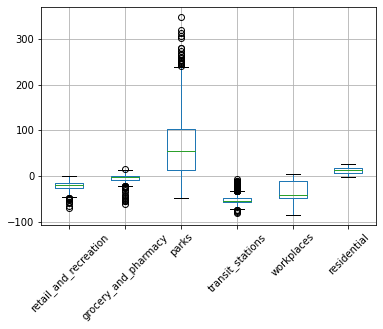

In [10]:
print("Percent changes for types of locations")
mob_df.boxplot(["retail_and_recreation","grocery_and_pharmacy","parks","transit_stations","workplaces","residential"], rot=45)


<AxesSubplot:>

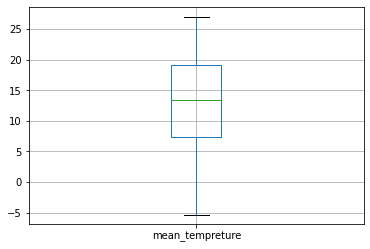

In [14]:
weather_df.boxplot(column="mean_tempreture")

<AxesSubplot:>

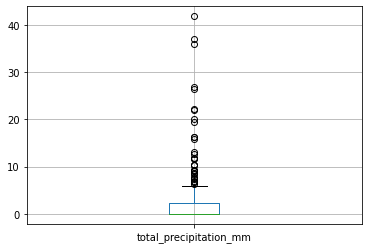

In [15]:
weather_df.boxplot(column="total_precipitation_mm")

### Pie charts

<AxesSubplot:title={'center':'fatal cases per phu'}, ylabel='fatal'>

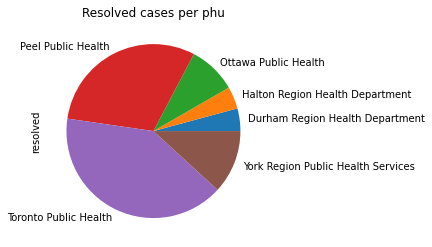

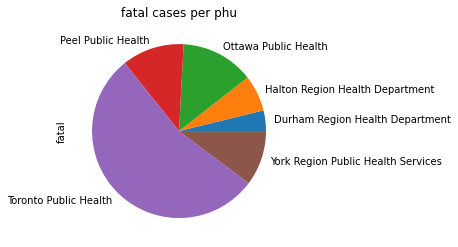

In [58]:
# fatal per phu, resolved per phu, unresolved per phu
fact_phu_df.plot.pie(y='resolved', title="Resolved cases per phu", legend=False)
fact_phu_df.plot.pie(y='fatal', title="fatal cases per phu", legend=False)


### Histograms and bar graphs

array([[<AxesSubplot:title={'center':'mean_tempreture'}>]], dtype=object)

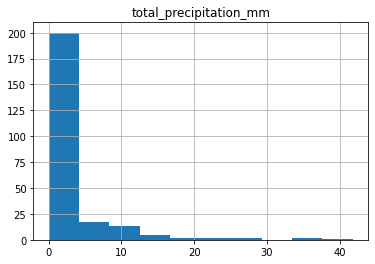

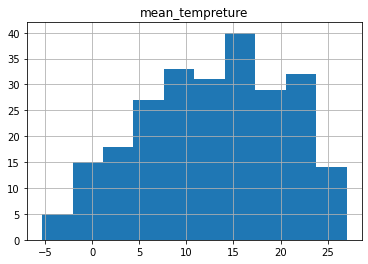

In [17]:
weather_df.hist(column="total_precipitation_mm")
weather_df.hist(column="mean_tempreture")

<AxesSubplot:xlabel='day_name'>

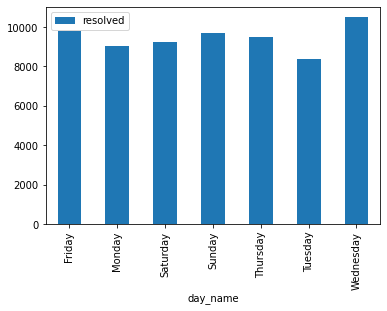

In [62]:
reported_date_fact_df.head()
reported_date_fact_df.groupby("day_name").sum().plot.bar( y="resolved")

(47905, 23)
                            resolved  fatal
case_acquisition age_group                 
CC               20s            8250      0
                 30s             590    161
                 40s            5021      0
                 50s           10122     20
                 80s            7293      0


<AxesSubplot:xlabel='case_acquisition,age_group'>

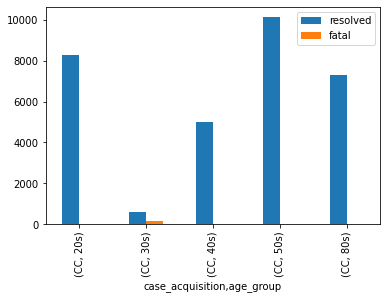

In [106]:
print(reported_date_fact_df.shape)
case_acquisition = reported_date_fact_df[["age_group","case_acquisition","resolved","fatal"]].groupby(["case_acquisition","age_group"]).sum().head()
print(case_acquisition.head(10))
case_acquisition.plot.bar()

  age_group  outbreak  resolved  fatal
0       20s         0      7762     13
1       20s         1      1117    175
2       30s         0      6919     85
3       30s         1      1072    130
4       40s         0      9065     37


<AxesSubplot:title={'center':'fatal cases per age not caused by outbreak'}, xlabel='age_group'>

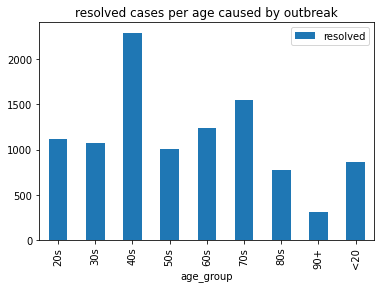

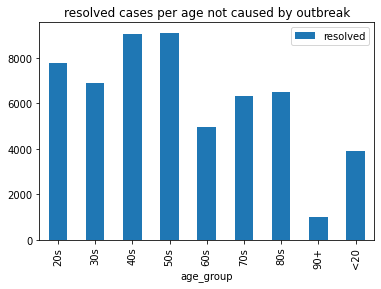

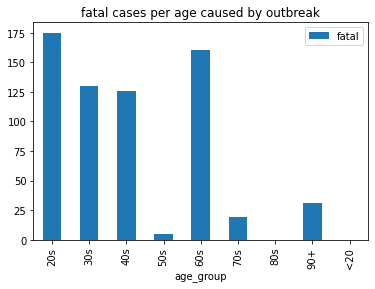

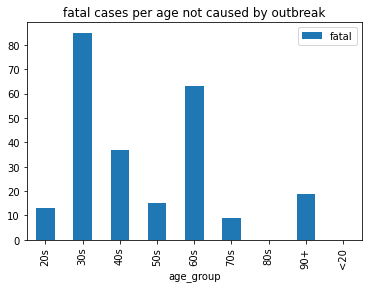

In [121]:
#mean age for outbreak
outbreak_fact_df = reported_date_fact_df[["age_group","outbreak", "resolved","fatal"]].groupby(["age_group","outbreak"]).sum().reset_index() 
print(outbreak_fact_df.head())
outbreak_fact_df.loc[outbreak_fact_df['outbreak']==1].plot.bar(x='age_group', y='resolved', title='resolved cases per age caused by outbreak')
outbreak_fact_df.loc[outbreak_fact_df['outbreak']==0].plot.bar(x='age_group', y='resolved', title='resolved cases per age not caused by outbreak')
outbreak_fact_df.loc[outbreak_fact_df['outbreak']==1].plot.bar(x='age_group', y='fatal', title='fatal cases per age caused by outbreak')
outbreak_fact_df.loc[outbreak_fact_df['outbreak']==0].plot.bar(x='age_group', y='fatal', title='fatal cases per age not caused by outbreak')

<AxesSubplot:xlabel='age_group'>

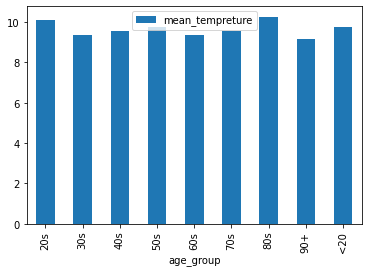

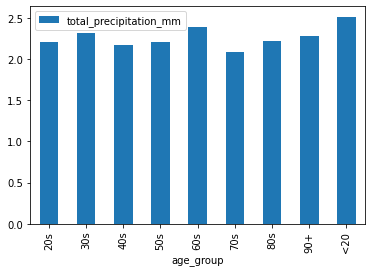

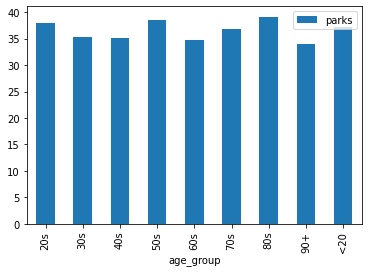

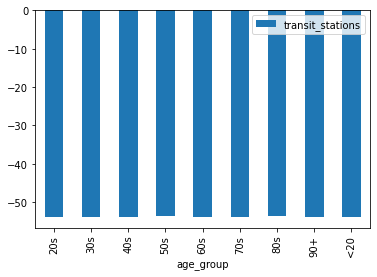

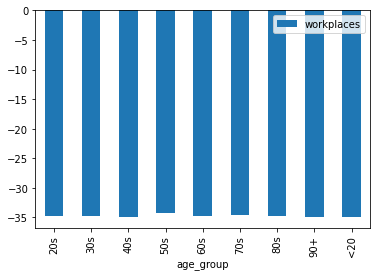

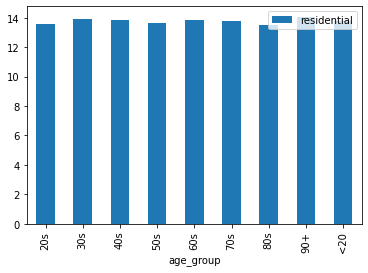

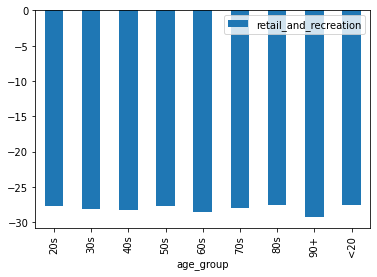

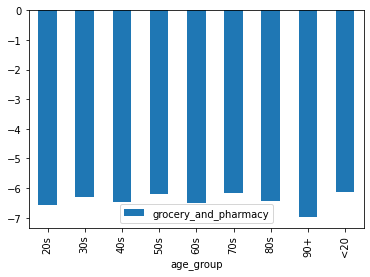

In [107]:
#mean age for each weather 
weather_reported_date_df = reported_date_fact_df[["mean_tempreture", "total_precipitation_mm","age_group","date_id","retail_and_recreation","grocery_and_pharmacy","parks","workplaces","transit_stations","residential"]].groupby(["age_group"]).mean().reset_index()
weather_reported_date_df.plot.bar(x="age_group",y="mean_tempreture")
weather_reported_date_df.plot.bar(x="age_group",y="total_precipitation_mm")

#mean age vs mobility_trends parks/work/transit
weather_reported_date_df.plot.bar(x="age_group",y="parks")
weather_reported_date_df.plot.bar(x="age_group",y="transit_stations")
weather_reported_date_df.plot.bar(x="age_group",y="workplaces")
weather_reported_date_df.plot.bar(x="age_group",y="residential")
weather_reported_date_df.plot.bar(x="age_group",y="retail_and_recreation")
weather_reported_date_df.plot.bar(x="age_group",y="grocery_and_pharmacy")


In [ ]:
#processing for bar graphs

fact_df_person_indexed = fact_df_person.reset_index(level="gender")

def resolved_female(row, col_to_return):
    if row["gender"]=="FEMALE":
        return  row[col_to_return]
    return 0

def resolved_male(row, col_to_return):
    if row["gender"]=="MALE":
        return  row[col_to_return]
    return 0

fact_df_person_indexed["resolved_female"] = fact_df_person_indexed.apply (lambda row: resolved_female(row,"resolved"), axis=1)
fact_df_person_indexed["resolved_male"] = fact_df_person_indexed.apply (lambda row: resolved_male(row,"resolved"), axis=1)

fact_df_person_indexed["fatal_female"] = fact_df_person_indexed.apply (lambda row: resolved_female(row,"fatal"), axis=1)
fact_df_person_indexed["fatal_male"] = fact_df_person_indexed.apply (lambda row: resolved_male(row, "fatal"), axis=1)

regrouped_person_df = fact_df_person_indexed[["resolved_female","resolved_male","fatal_female","fatal_male"]].groupby("age_group").sum()
print(regrouped_person_df.head())

           resolved_female  resolved_male  fatal_female  fatal_male
age_group                                                          
20s                    629           8250           188           0
30s                      0           7991             0         215
40s                  11359              0           163           0
50s                   5598           4524             1          19
60s                   1416           4803           218           5


<AxesSubplot:title={'center':'Fatal cases per gender'}, xlabel='age_group'>

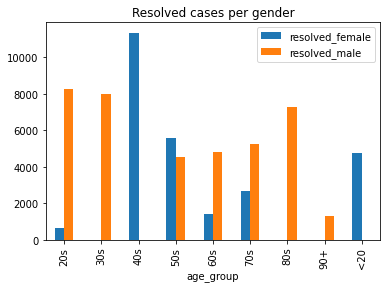

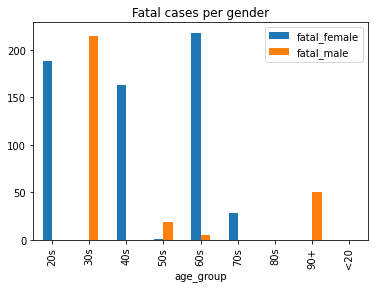

In [46]:
regrouped_person_df.plot.bar(y=["resolved_female","resolved_male"], subplots=False, use_index=True, sharex=True, title = "Resolved cases per gender")
regrouped_person_df.plot.bar(y=["fatal_female","fatal_male"], subplots=False, use_index=True, sharex=True, title = "Fatal cases per gender")


### Scatter plots

   date_id  mean_tempreture       parks  resolved  total_precipitation_mm  \
0      213        24.000000  172.653846        56                2.850000   
1      214        23.843750   39.343750       248               36.937500   
2      215        20.960784  120.470588        52               21.937255   
3      216        20.466667   11.764706        56               14.333333   
4      217        19.393878  107.959184        51                0.244898   

   workplaces  transit_stations  residential  
0   -9.057692        -35.000000     1.307692  
1  -15.781250        -50.625000     3.781250  
2  -77.333333        -68.666667    20.098039  
3  -54.431373        -58.784314    17.470588  
4  -51.714286        -55.285714    15.489796  


<AxesSubplot:xlabel='residential', ylabel='resolved'>

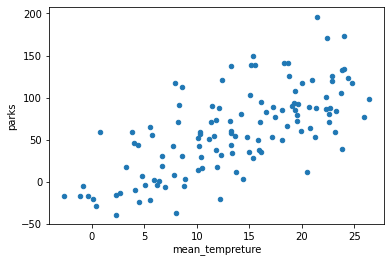

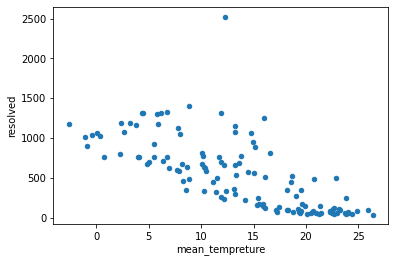

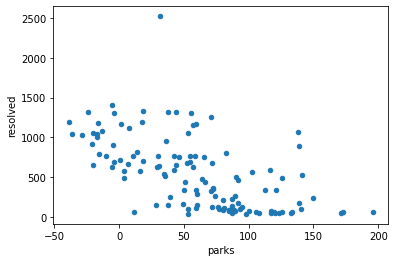

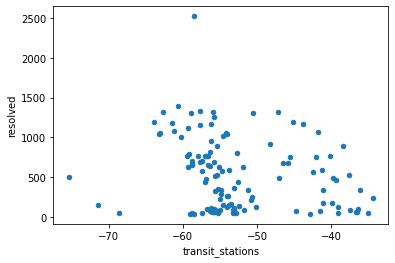

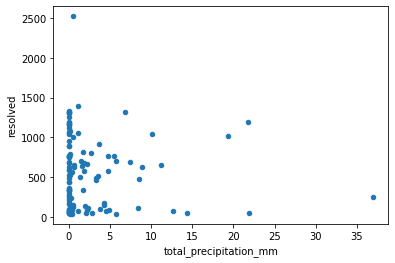

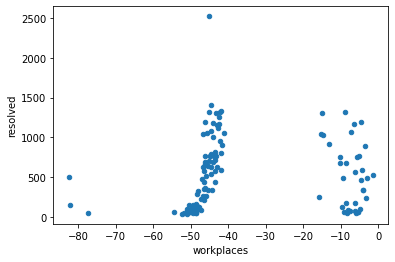

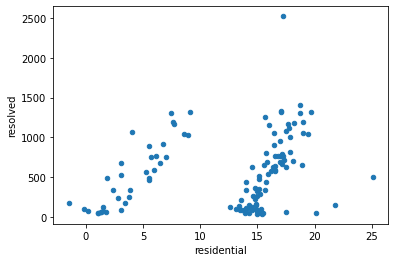

In [98]:
grouped_reported_date_fact_df = reported_date_fact_df[["mean_tempreture","date_id","parks","resolved","transit_stations","total_precipitation_mm","workplaces","residential"]].groupby(["date_id"]).agg(
    {'mean_tempreture':'mean','parks':'mean','resolved':'sum', "total_precipitation_mm":'mean',"workplaces":'mean',"workplaces":'mean',"transit_stations":'mean',"residential":'mean'})
grouped_reported_date_fact_df.reset_index(inplace=True)
print(grouped_reported_date_fact_df.head())

# temperature vs parks
grouped_reported_date_fact_df.plot.scatter(x="mean_tempreture",y="parks")

#temperature vs total cases resolved on reported date
grouped_reported_date_fact_df.plot.scatter(x="mean_tempreture",y="resolved")

#mobility vs total case per reported date
grouped_reported_date_fact_df.plot.scatter(x="parks",y="resolved")
grouped_reported_date_fact_df.plot.scatter(x="transit_stations",y="resolved")
grouped_reported_date_fact_df.plot.scatter(x="total_precipitation_mm",y="resolved")
grouped_reported_date_fact_df.plot.scatter(x="workplaces",y="resolved")
grouped_reported_date_fact_df.plot.scatter(x="residential",y="resolved")



In [99]:
#todo:  outbreak vs gender
